# LAB: Workflow de Datos. Limpieza y sumarización de datos para el Desafío 3.

## Introducción

La idea de este lab es comenzar a trabajar con los datos del Desafío 3. Vamos a tratar de comenzar con el proceso de limpieza, sumarización y análisis exploratorio del dataset de Properatti. Como recordarán, el objetivo final es el desarrollo de un tasador automático a ser aplicado a las próximas propiedades que sean comercializadas por la empresa mediante un modelo de regresión. Como verán, el dataset está sumamente "sucio" y require un intenso proceos de limpieza.

El dataset contiene información referida al primer semestre de 2017 de las propiedades comercializables por la empresa:

* Fecha de creación
* Tipo de la propiedad (house, apartment, ph)
* Operación del aviso (sell, rent)
* Nombre del lugar
* Nombre del lugar + nombre de sus ‘padres’
* ID de geonames del lugar (si está disponible)
* Latitud,Longitud
* Precio original del aviso
* Moneda original del aviso (ARS, USD)
* Precio del aviso en moneda local (ARS)
* Precio aproximado en USD
* Superficie en m²
* Superficie cubierta en m²
* Precio en USD/m²
* Precio por m²
* N° de piso, si corresponde
* Ambientes
* URL en Properati
* Descripción
* Título
* URL de un thumbnail de la primer foto


Una vez terminada la limpieza, aquellos que se animen pueden empezar a probar algunos modelos simples de regresión.


## Objetivos de aprendizaje

* Practicar técnicas de limpieza de datos de tipo texto
* Practicar conversiones de tipo de dato
* Practicar rellenar datos faltantes con 0s o promedios
* Practicar técnicas para trabajo con datos categóricos
* Transformar datos a información útil
* Realizar un primer análisis exploratorio
* BONUS: realizar un primer modelo de regresión

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from sklearn import metrics

In [7]:
# Cargar la data
df = pd.read_csv('Data/properatti.csv')  # DATOS DE PROPIEDADES EN VENTA PROPERATI
print(df.columns)
df.head()

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


# Limpiar el dataset
Practiquemos nuestras capacidades para realizar limpieza de datos con el dataset de ventas de propiedades de Properatti. Si no recuerdan cómo hacer alguna de estas tareas, busquen en Internet o en clases anteriores de manipulación de datos.

Buscamos que completen las siguientes tareas:
* Quitar columnas redundantes
* Convertir las variables categóricas numéricas a integer
* Lidiar con los valores perdidos y/o erróneos en algunas variables clave: 

    + en este punto podría ser interesante realizar algo ligeramente más complejo que un simple rellenado en función de medias. Podría eventualmente imputar en función de medias condicionadas.
        * por ejemplo, los campos `lat` y `long` tienen, también, muchos casos perdidos. Quizás una estrategia posible sería tratar de imputar las coordenadas con la media de los casos en el mismo `place_name` -barrio-.
    + también podrían evaluar la posibilidad de extraer alguna información para completar los datos perdidos del campo "description" que contiene texto del aviso. 
        * por ejemplo, el campo `rooms` tiene una altísima cantidad de missing. Podrían intentar usando alguna expresión regex extraer información 

# Filtrar los Datos

En general, los mdoelos de precios suelen tener un carácter local. Es por eso que deberán elegir alguna zona o provincia para trabajar y estimar el modelo en base a dicha selección.

In [8]:
# Filtrar la zona elegida para estimar el modelo

df_caba = df[df['state_name'] == 'Capital Federal'].copy()
df_caba.describe()

,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,32316.000000,3.103000e+04,23770.000000,23770.000000,2.901800e+04,2.901800e+04,2.901800e+04,26437.000000,29977.000000,23434.000000,2.732400e+04,3009.000000,15325.000000,6.592000e+03
mean,61151.927095,3.528152e+06,-34.601818,-58.436237,3.829522e+05,4.757013e+06,2.696032e+05,119.222453,97.785802,3116.930444,6.108162e+03,12.661017,2.713475,6.356514e+03
std,34260.728927,5.504745e+05,0.036491,0.052454,1.081570e+06,8.073753e+06,4.575790e+05,1248.215227,1096.669779,3681.030087,2.365400e+04,82.294183,1.543438,1.741894e+05
min,0.000000,3.427366e+06,-38.416097,-63.616672,5.500000e+03,9.005064e+04,5.103610e+03,0.000000,0.000000,13.797467,3.208556e+00,1.000000,1.000000,1.000000e+00
25%,31210.750000,3.429760e+06,-34.621223,-58.465298,1.090000e+05,1.852672e+06,1.050000e+05,42.000000,38.000000,1966.062830,2.190917e+03,2.000000,1.000000,1.200000e+03
50%,60876.000000,3.433775e+06,-34.602259,-58.437634,1.658000e+05,2.774792e+06,1.572610e+05,62.000000,55.000000,2468.750000,2.777419e+03,4.000000,3.000000,2.000000e+03
75%,87955.250000,3.436003e+06,-34.582214,-58.404019,3.250000e+05,5.028682e+06,2.850000e+05,110.000000,95.000000,3076.923077,3.590000e+03,7.000000,4.000000,3.800000e+03
max,121219.000000,6.693230e+06,-34.534530,-58.354956,5.000000e+07,8.212711e+08,4.654544e+07,200000.000000,187000.000000,206333.333333,2.600000e+06,2509.000000,22.000000,1.000150e+07


# Análisis exploratorio

Como estamos intentando predecir precios por metro cuadrado es importante realizar una primera vista y exploración de los datos.

In [9]:
# Calculo de correlacion entre features


In [10]:
# Analisis exploratorio, graficos...


¿En qué barrios los precios por $m^2$ son más altos? 

In [11]:
df_caba.sort_values(by='price_usd_per_m2', ascending= False).head()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
26637,26637,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,3436003.0,"-34.6222039,-58.416089",-34.622204,...,33.0,206333.333333,206333.333333,NaN,1.0,NaN,http://www.properati.com.ar/17rbf_venta_depart...,Departamento 1 ambiente divisible Depto en CU...,"Tu depa, ingresa con $ 29.000 y cuotas en pesos",https://thumbs4.properati.com/0/S-zC2PgWGFWuGB...
26037,26037,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,3436003.0,NaN,NaN,...,30.0,173826.066667,173826.066667,NaN,1.0,NaN,http://www.properati.com.ar/17qou_venta_depart...,lan840- DEPTO FINANCIACION DIRECTA EN PESOSAnt...,lan840- DEPTO FINANCIACION DIRECTA EN PESOS,https://thumbs4.properati.com/0/cr-NvID1VVGL4R...
26193,26193,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,3436003.0,NaN,NaN,...,35.0,104486.114286,104486.114286,NaN,1.0,NaN,http://www.properati.com.ar/17quf_venta_depart...,fac030- Depto anticipo en 10 meses y saldo en ...,fac030- Depto anticipo en 10 meses y saldo en ...,https://thumbs4.properati.com/5/6ieB5ag091SbEO...
25853,25853,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,3436003.0,NaN,NaN,...,30.0,78533.333333,78533.333333,NaN,1.0,NaN,http://www.properati.com.ar/17qgx_venta_depart...,bf221- INCREIBLE FORMA DE PAGO- ANT Y CUOTAS D...,bf221- INCREIBLE FORMA DE PAGO- ANT Y CUOTAS D...,https://thumbs4.properati.com/5/-g7Ufd8oE1D5gC...
107057,107057,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0,"-34.5832756,-58.426027",-34.583276,...,98.0,44900.000000,4581.632653,NaN,NaN,NaN,http://www.properati.com.ar/1bxbi_venta_depart...,CODIGO: 1237-69 ubicado en: Paraguay 4700 - P...,"Departamento en Venta en Palermo, Capital Federal",https://thumbs4.properati.com/9/SW14tH2nD5p8RX...


In [12]:
df_caba['properati_url'].values

array([ 'http://www.properati.com.ar/15bo8_venta_ph_mataderos_lavadero_patio_inmobiliaria-fedele',
       'http://www.properati.com.ar/15bod_venta_departamentos_mataderos_lavadero_placard_inmobiliaria-fedele',
       'http://www.properati.com.ar/15boh_venta_ph_liniers_patio_g-goffredo',
       ...,
       'http://www.properati.com.ar/1cja2_venta_departamento_belgrano_balcon_suite_parrilla_piscina_quincho_toilette_vestidor_luminoso_lujoso_garage_tenis_impecable_federico-galceran-propiedades_glf',
       'http://www.properati.com.ar/1cja7_venta_departamento_villa-urquiza_holmberg_2300_balcon_lavadero_parrilla_terraza_electrogeno_garage_amenities_placard_aire-acondicionado_estrenar_triada-propiedades_geg',
       'http://www.properati.com.ar/1cjaa_venta_departamento_capital-federal_baulera_lavadero_lujoso_dependencias_izrastzoff-compania-inmobiliaria'], dtype=object)

¿En qué barrios hay una mayor cantidad de viviendas para su venta?

In [13]:
df_caba.groupby('place_name')[['operation']].count().sort_values(by='operation', ascending = False).head()

,operation
place_name,
Belgrano,2992
Palermo,2885
Caballito,2273
Villa Urquiza,1629
Recoleta,1547


¿ En qué barrios hay una mayor dispersión de precios?

In [14]:
df_caba.groupby('place_name')[['price_usd_per_m2']].std().sort_values(by='price_usd_per_m2', ascending = False).head()

,price_usd_per_m2
place_name,
Boedo,13188.768866
San Cristobal,9768.989436
Congreso,3755.718513
Almagro,3262.402046
Boca,3046.694643


¿Qué tipo de propiedad presenta los mayores precios? ¿Cuál las mayores dispersiones?

In [15]:
df_caba.groupby('property_type')[['price_usd_per_m2']].mean().sort_values(by='price_usd_per_m2', ascending = False)

,price_usd_per_m2
property_type,
apartment,3324.464870
store,2899.667204
PH,1695.517729
house,1546.701574


In [16]:
df_caba.groupby('property_type')[['price_usd_per_m2']].std().sort_values(by='price_usd_per_m2', ascending = False)

,price_usd_per_m2
property_type,
apartment,3892.824716
store,2222.673859
house,1654.290655
PH,887.360632


In [17]:
df_caba.drop(['operation','Unnamed: 0','country_name','image_thumbnail'],axis=1, inplace=True)

In [18]:
df_caba[df_caba['price_usd_per_m2'] > 10000]
df_caba = df_caba[df_caba['price_usd_per_m2'] < 10000]

In [19]:
df_caba.groupby('place_name')[['price_usd_per_m2']].mean().sort_values(by='price_usd_per_m2', ascending = False).head()

,price_usd_per_m2
place_name,
Puerto Madero,5977.203152
Palermo Chico,4424.798743
Las Cañitas,3476.175811
Recoleta,3316.419018
Palermo,3313.890780


Continua realizando un análisis exploratorio del dataset...

In [40]:
df_caba_v1 = df_caba[['lat','lon','property_type','place_name','surface_total_in_m2','price_usd_per_m2']]
#df_caba_v1 = df_caba_v1[df_caba_v1['surface_covered_in_m2'].notnull()]
df_caba_v1.head()

,lat,lon,property_type,place_name,surface_total_in_m2,price_usd_per_m2
0,-34.661824,-58.508839,PH,Mataderos,55.0,1127.272727
2,-34.652262,-58.522982,apartment,Mataderos,55.0,1309.090909
7,-34.559873,-58.443362,apartment,Belgrano,45.0,3066.666667
8,-34.559873,-58.443362,apartment,Belgrano,65.0,3000.000000
13,NaN,NaN,apartment,Palermo Soho,50.0,2234.000000


In [41]:
df_caba_v1.isnull().sum(axis=0)

lat                    5725
lon                    5725
property_type             0
place_name                0
surface_total_in_m2       0
price_usd_per_m2          0
dtype: int64

In [42]:
len(df_caba_v1.place_name.unique())

62

In [43]:
from IPython.display import display
def proceso(df):
    df.lat = df.lat.fillna(df.lat.mean())
    df.lon = df.lon.fillna(df.lon.mean())
    return df

df_fill_na = df_caba_v1.groupby('place_name').apply(proceso)
df_fill_na.head()



,lat,lon,property_type,place_name,surface_total_in_m2,price_usd_per_m2
0,-34.661824,-58.508839,PH,Mataderos,55.0,1127.272727
2,-34.652262,-58.522982,apartment,Mataderos,55.0,1309.090909
7,-34.559873,-58.443362,apartment,Belgrano,45.0,3066.666667
8,-34.559873,-58.443362,apartment,Belgrano,65.0,3000.000000
13,-34.590397,-58.424409,apartment,Palermo Soho,50.0,2234.000000


In [44]:
df_fill_na.isnull().sum(axis=0)

lat                    0
lon                    0
property_type          0
place_name             0
surface_total_in_m2    0
price_usd_per_m2       0
dtype: int64

In [45]:
df = df_fill_na
df_dummies = pd.get_dummies(df, drop_first= True)
df_dummies = df_dummies[df_dummies.lat > -36]
df_dummies.head()

,lat,lon,surface_total_in_m2,price_usd_per_m2,property_type_apartment,property_type_house,property_type_store,place_name_Agronomía,place_name_Almagro,place_name_Balvanera,...,place_name_Villa Lugano,place_name_Villa Luro,place_name_Villa Ortuzar,place_name_Villa Pueyrredón,place_name_Villa Real,place_name_Villa Riachuelo,place_name_Villa Santa Rita,place_name_Villa Soldati,place_name_Villa Urquiza,place_name_Villa del Parque
0,-34.661824,-58.508839,55.0,1127.272727,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-34.652262,-58.522982,55.0,1309.090909,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-34.559873,-58.443362,45.0,3066.666667,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-34.559873,-58.443362,65.0,3000.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,-34.590397,-58.424409,50.0,2234.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
y = df_dummies[['price_usd_per_m2']]
X = df_dummies.drop(['price_usd_per_m2'],axis=1)
display(X.head(),y.head())

,lat,lon,surface_total_in_m2,property_type_apartment,property_type_house,property_type_store,place_name_Agronomía,place_name_Almagro,place_name_Balvanera,place_name_Barracas,...,place_name_Villa Lugano,place_name_Villa Luro,place_name_Villa Ortuzar,place_name_Villa Pueyrredón,place_name_Villa Real,place_name_Villa Riachuelo,place_name_Villa Santa Rita,place_name_Villa Soldati,place_name_Villa Urquiza,place_name_Villa del Parque
0,-34.661824,-58.508839,55.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-34.652262,-58.522982,55.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-34.559873,-58.443362,45.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-34.559873,-58.443362,65.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,-34.590397,-58.424409,50.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,price_usd_per_m2
0,1127.272727
2,1309.090909
7,3066.666667
8,3000.000000
13,2234.000000


In [47]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 0)

model = LinearRegression()
model.fit(Xtrain,ytrain)

y_predict = model.predict(Xtest)

Train = Xtrain.join(ytrain)
Test = Xtest.join(ytest)
print('Train size: ', Train.shape)
print('Test size: ', Test.shape)
print('X test size: ', Xtest.shape)
print('Y test size: ', ytest.shape)
print('X train size: ', Xtrain.shape)
print('Y train size: ', ytrain.shape)
Test.head()

Train size:  (17073, 68)
Test size:  (5691, 68)
X test size:  (5691, 67)
Y test size:  (5691, 1)
X train size:  (17073, 67)
Y train size:  (17073, 1)


,lat,lon,surface_total_in_m2,property_type_apartment,property_type_house,property_type_store,place_name_Agronomía,place_name_Almagro,place_name_Balvanera,place_name_Barracas,...,place_name_Villa Luro,place_name_Villa Ortuzar,place_name_Villa Pueyrredón,place_name_Villa Real,place_name_Villa Riachuelo,place_name_Villa Santa Rita,place_name_Villa Soldati,place_name_Villa Urquiza,place_name_Villa del Parque,price_usd_per_m2
14876,-34.605610,-58.388140,205.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1121.951220
42239,-34.624567,-58.424604,56.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1928.571429
80509,-34.620935,-58.381463,109.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1972.477064
111502,-34.607305,-58.470908,60.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1716.666667
37121,-34.629819,-58.485702,50.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1500.000000


In [48]:
y_predict

array([[ 2372.69290952],
       [ 2049.91918186],
       [ 2027.92433592],
       ..., 
       [ 1844.55747436],
       [ 1872.40566145],
       [ 3132.76615017]])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


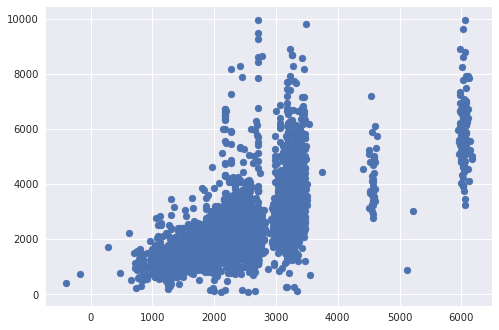

In [49]:
plt.scatter(y_predict,ytest)

In [50]:
from sklearn import metrics
import numpy as np
print ('MAE:', metrics.mean_absolute_error(ytest, y_predict))
print ('MSE:', metrics.mean_squared_error(ytest, y_predict))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, y_predict)))
print ('R2:', metrics.r2_score(ytest, y_predict))

MAE: 578.381992677
MSE: 760690.425835
RMSE: 872.175685189
R2: 0.455685788423


In [51]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15934, 67) (15934, 1)
(6830, 67) (6830, 1)


In [53]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada

al_ridge = np.linspace(0.0001, 3, 30)
al_lasso = np.linspace(0.0001, 3, 30)
kf = KFold(n_splits=5, shuffle=True, random_state=12)

# Instanciamos los modelos

lm = LinearRegression()
lmRidgeCV = RidgeCV(alphas=al_ridge, cv=kf, normalize=True)
lmLassoCV = LassoCV(alphas=al_lasso, cv=kf, normalize=True)

In [54]:
# Hacemos los fits respectivos

lm.fit(X_train, y_train)
lmRidgeCV.fit(X_train, y_train)
lmLassoCV.fit(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=array([  1.00000e-04,   1.03545e-01,   2.06990e-01,   3.10434e-01,
         4.13879e-01,   5.17324e-01,   6.20769e-01,   7.24214e-01,
         8.27659e-01,   9.31103e-01,   1.03455e+00,   1.13799e+00,
         1.24144e+00,   1.34488e+00,   1.44833e+00,   1.55177e+00,
         1.65522e+00,   1...     2.48278e+00,   2.58622e+00,   2.68967e+00,   2.79311e+00,
         2.89656e+00,   3.00000e+00]),
    copy_X=True, cv=KFold(n_splits=5, random_state=12, shuffle=True),
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=True, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [55]:
print('Alpha Ridge:',lmRidgeCV.alpha_,'\n'
      'Alpha LASSO:',lmLassoCV.alpha_,'\n')

Alpha Ridge: 0.0001 
Alpha LASSO: 0.0001 



In [56]:
# Calculamos el R2

print("Score Train Lineal:", lm.score(X_train, y_train),"\n"
      "Score Train Ridge:",  lmRidgeCV.score(X_train, y_train),"\n"
      "Score Train Lasso:",  lmLassoCV.score(X_train, y_train))

# Calculamos el MSE

lmpred_Tr = lm.predict(X_train)
lmRidgepred_Tr = lmRidgeCV.predict(X_train)
lmLassoepred_Tr = lmLassoCV.predict(X_train)

print("Train MSE lineal=", mean_squared_error(y_train,lmpred_Tr), "\n"
      "Train MSE Ridge=",  mean_squared_error(y_train,lmRidgepred_Tr), "\n"
      "Train MSE Lasso=",  mean_squared_error(y_train,lmLassoepred_Tr))

Score Train Lineal: 0.471434868917 
Score Train Ridge: 0.471434868814 
Score Train Lasso: 0.471434018736
Train MSE lineal= 725129.76913 
Train MSE Ridge= 725129.769271 
Train MSE Lasso= 725130.935479


In [57]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

lmpred_Te = lm.predict(X_test)
lmRidgepred_Te = lmRidgeCV.predict(X_test)
lmLassoepred_Te = lmLassoCV.predict(X_test)

# Testeo final del modelo sobre Test Set

print("Test Score lineal=", mean_squared_error(y_test,lmpred_Te), "\n"
      "Test Score Ridge=",  mean_squared_error(y_test,lmRidgepred_Te), "\n"
      "Test Score Lasso=",  mean_squared_error(y_test,lmLassoepred_Te))

Test Score lineal= 2009071.74216 
Test Score Ridge= 2009050.89291 
Test Score Lasso= 2008028.99124
